<a href="https://colab.research.google.com/github/ZibaGandomkar/3DCNN-Vis/blob/master/CV_Classifier_with_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zibaga","key":"b8bdfd0b11f675a48a12721082b58f97"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d zibaga/cardio-v2

100% 6.30G/6.30G [04:52<00:00, 25.9MB/s]
100% 6.30G/6.30G [04:52<00:00, 23.1MB/s]


In [5]:
import zipfile
with zipfile.ZipFile('/content/cardio-v2.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Data')

In [10]:
import tensorflow as tf
from tensorflow import keras
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()


with strategy.scope():
    inputs = tf.keras.layers.Input(shape=(300,300,3)) 
    outputs = tf.keras.applications.efficientnet.EfficientNetB3(include_top=True, weights=None, classes=2)(inputs)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"]
    )

model.summary()

epochs = 40  
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
valid_generator = valid_datagen.flow_from_directory(
    '/content/Data/test', shuffle=False,batch_size=16, target_size=(300,300))

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=10,
      horizontal_flip=True,
      width_shift_range=0.1, height_shift_range=0.1,
      shear_range=0.05, zoom_range=0.2,samplewise_center=True, samplewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    '/content/Data/train', shuffle=True,batch_size=16, target_size=(300,300))
hist = model.fit(train_generator, epochs=epochs, validation_data=valid_generator, verbose=1)

Not connected to a TPU runtime. Using CPU/GPU strategy
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 2)                10786609  
                                                                 
Total params: 10,786,609
Trainable params: 10,699,306
Non-trainable params: 87,303
_________________________________________________________________
Found 2144 images belonging to 2 classes.
Found 15382 images belonging to 2 classes.
Epoch 1/40
962/962 [==============================] - 609s 615ms/step - loss: 0.8901 - accuracy: 0.6950 - val_loss: 0.8692 - val_accuracy: 0.5709
Epoch 2/40
962/962 [==============================] - 587s 610ms/step - loss: 0.6407 - accuracy: 0.7071 - val_loss: 0.7970 - val_accuracy: 0.5709
Epoch 

KeyboardInterrupt: ignored

In [15]:
IMG_SIZE = 300
def build_model(num_classes):
    inputs = tf.keras.layers.Input(shape=(300,300,3)) 
    model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet")(inputs)

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [16]:
with strategy.scope():
    model = build_model(num_classes=2)

epochs = 25 
 
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
valid_generator = valid_datagen.flow_from_directory(
    '/content/Data/test', shuffle=False,batch_size=16, target_size=(300,300))

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=10,
      horizontal_flip=True,
      width_shift_range=0.1, height_shift_range=0.1,
      shear_range=0.05, zoom_range=0.2)

train_generator = train_datagen.flow_from_directory(
    '/content/Data/train', shuffle=True,batch_size=16, target_size=(300,300))
hist = model.fit(train_generator, epochs=epochs, validation_data=valid_generator, verbose=2)

Found 2144 images belonging to 2 classes.
Found 15382 images belonging to 2 classes.
Epoch 1/25
962/962 - 573s - loss: 1.2490 - accuracy: 0.6480 - val_loss: 1.1440 - val_accuracy: 0.5704 - 573s/epoch - 595ms/step
Epoch 2/25
962/962 - 552s - loss: 0.7782 - accuracy: 0.6967 - val_loss: 0.8669 - val_accuracy: 0.5709 - 552s/epoch - 574ms/step
Epoch 3/25
962/962 - 552s - loss: 0.6456 - accuracy: 0.7060 - val_loss: 0.7146 - val_accuracy: 0.5709 - 552s/epoch - 574ms/step
Epoch 4/25
962/962 - 553s - loss: 0.6128 - accuracy: 0.7088 - val_loss: 0.7973 - val_accuracy: 0.5709 - 553s/epoch - 574ms/step
Epoch 5/25
962/962 - 555s - loss: 0.6133 - accuracy: 0.7091 - val_loss: 0.7251 - val_accuracy: 0.5639 - 555s/epoch - 577ms/step
Epoch 6/25
962/962 - 555s - loss: 0.6077 - accuracy: 0.7101 - val_loss: 0.7439 - val_accuracy: 0.4454 - 555s/epoch - 577ms/step
Epoch 7/25
962/962 - 554s - loss: 0.6113 - accuracy: 0.7106 - val_loss: 0.7218 - val_accuracy: 0.4622 - 554s/epoch - 575ms/step
Epoch 8/25
962/962 

KeyboardInterrupt: ignored

In [28]:
import tensorflow as tf
from tensorflow import keras
img_input = tf.keras.layers.Input(shape=(300,300,3))
#inputs = tf.keras.layers.Concatenate()([img_input, img_input, img_input])    
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights='imagenet')(img_input)
# Rebuild top
top_dropout_rate = 0.2
oup = tf.keras.layers.GlobalAveragePooling2D()(base_model)
oup = tf.keras.layers.BatchNormalization()(oup)
oup = tf.keras.layers.Dropout(top_dropout_rate)(oup)
oup = tf.keras.layers.Dense(2, activation='softmax')(oup)
model = tf.keras.Model (inputs=[img_input], outputs=[oup])

In [29]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, None, None, 1536)  10783535 
                                                                 
 global_average_pooling2d_4   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dropout_3 (Dropout)         (None, 1536)              0         
                                                                 
 dense_6 (Dense)             (None, 2)                 3074

In [36]:
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
valid_generator = valid_datagen.flow_from_directory(
    '/content/Data/test', shuffle=False,batch_size=16, target_size=(300,300))

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=10,
      horizontal_flip=True,
      width_shift_range=0.1, height_shift_range=0.1,
      shear_range=0.05, zoom_range=0.2)

train_generator = train_datagen.flow_from_directory(
    '/content/Data/train', shuffle=True,batch_size=16, target_size=(300,300))

Found 2144 images belonging to 2 classes.
Found 15382 images belonging to 2 classes.


In [34]:
train_generator.batch_size

32

In [37]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), 
  loss='binary_crossentropy',
  metrics=['accuracy'])

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=30, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps, class_weight={0:1, 1: 3})

Epoch 1/30
961/961 [==============================] - 550s 554ms/step - loss: 2.3921 - accuracy: 0.4688 - val_loss: 0.7722 - val_accuracy: 0.4291
Epoch 2/30
961/961 [==============================] - 530s 551ms/step - loss: 1.6345 - accuracy: 0.4490 - val_loss: 15.0842 - val_accuracy: 0.4291
Epoch 3/30
961/961 [==============================] - 529s 550ms/step - loss: 1.4805 - accuracy: 0.4368 - val_loss: 1.8264 - val_accuracy: 0.4370
Epoch 4/30
961/961 [==============================] - 529s 550ms/step - loss: 1.3420 - accuracy: 0.4268 - val_loss: 6.1505 - val_accuracy: 0.4347
Epoch 5/30
961/961 [==============================] - 529s 550ms/step - loss: 1.2573 - accuracy: 0.4358 - val_loss: 10.6206 - val_accuracy: 0.4613
Epoch 6/30
961/961 [==============================] - 528s 550ms/step - loss: 1.1863 - accuracy: 0.4326 - val_loss: 6.1117 - val_accuracy: 0.5858
Epoch 7/30
961/961 [==============================] - 530s 551ms/step - loss: 1.1308 - accuracy: 0.4187 - val_loss: 0.7323

[Data Scorce](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

In [6]:
import matplotlib.pyplot as plt 
import torch.nn.functional as F 
import torch 
import numpy as np 

def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)

def show_grid(image,title = None):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)


def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


def view_classify(image,ps,label):
    
    class_name = ['neg', 'pos']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [15]:
class CFG:

  epochs =20                              # No. of epochs for training the model
  lr = 0.01                              # Learning rate
  batch_size = 8                         # Batch Size for Dataset

  #model_name = 'tf_efficientnet_b4_ns'    # Model name (we are going to import model from timm)
  model_name = 'resnet18'
  img_size = 800                        # Resize all the images to be 224 by 224

  # going to be used for loading dataset
  train_path='/content/Data/kaggle/train'
  validate_path='/content/Data/kaggle/test'
  test_path='/content/Data/kaggle/test'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

On which device we are on:cuda


In [10]:
from torchvision import transforms as T,datasets

In [16]:
train_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             T.RandomRotation(degrees=(-10,+10)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

validate_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

test_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

In [52]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [17]:
trainset=datasets.ImageFolder(CFG.train_path,transform=train_transform)
print("Trainset Size:  {}".format(len(trainset)))

Trainset Size:  11373


In [18]:
validateset=datasets.ImageFolder(CFG.validate_path,transform=validate_transform)
print("validateset Size:  {}".format(len(validateset)))

validateset Size:  1203


In [19]:
testset=datasets.ImageFolder(CFG.test_path,transform=test_transform)
print("testset Size:  {}".format(len(testset)))

testset Size:  1203


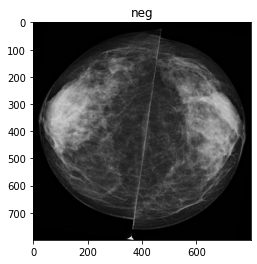

In [20]:
img,label = trainset[20]
#print(trainset.class_to_idx)

class_name =["neg","pos"]
show_image(img,class_name[label])

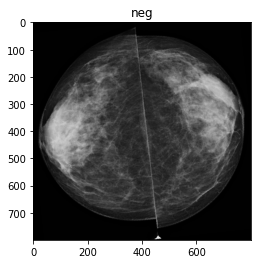

In [21]:
img,label = trainset[20]
#print(trainset.class_to_idx)

class_name =["neg","pos"]
show_image(img,class_name[label]) 

# randomly rotated

In [22]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [23]:
trainloader = DataLoader(trainset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) #Trainset Size:  5216 / batch_size: 16 = 326(No. of batches in trainloader) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

No. of batches in trainloader:1422
No. of Total examples:11373


In [24]:
validationloader = DataLoader(validateset,batch_size=CFG.batch_size,shuffle=False)
print("No. of batches in validationloader:{}".format(len(validationloader))) #validationset Size:  16 / batch_size: 16 = 1(No. of batches in validationloader) 
print("No. of Total examples:{}".format(len(validationloader.dataset)))

No. of batches in validationloader:151
No. of Total examples:1203


In [25]:
testloader = DataLoader(testset,batch_size=CFG.batch_size,shuffle=False)
print("No. of batches in testloader:{}".format(len(testloader))) #testset Size:  624 / batch_size: 16 = 39(No. of batches in testloader) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in testloader:151
No. of Total examples:1203


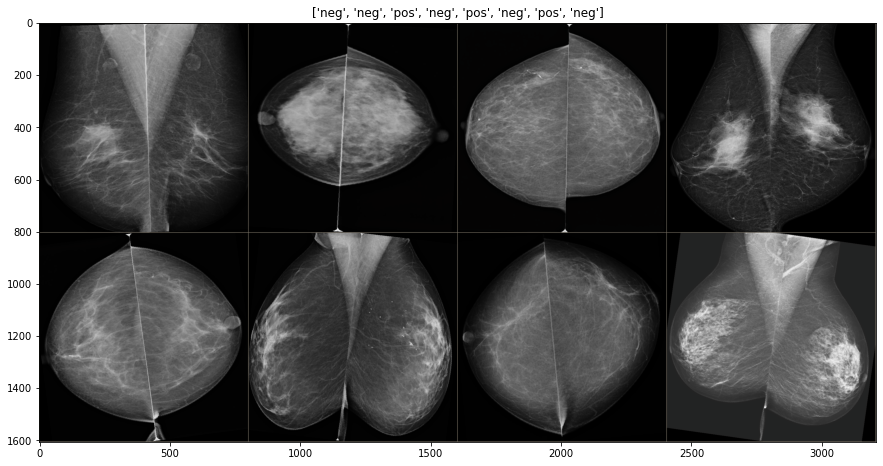

In [26]:
dataiter = iter(trainloader)
images,labels = dataiter.next()

out = make_grid(images,nrow=4)

show_grid(out,title = [class_name[x] for x in labels])

In [27]:
!pip install timm # install PyTorch Image Models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 4.1 MB/s 
     |████████████████████████████████| 182 kB 86.6 MB/s 


In [45]:
from torch import nn
import torch.nn.functional as F
import timm # PyTorch Image Models

model = timm.create_model('resnet34',pretrained=True) #load pretrained model

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34-43635321.pth" to /root/.cache/torch/hub/checkpoints/resnet34-43635321.pth


In [46]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [47]:
#let's update the pretarined model:
#for param in model.parameters():
 # param.requires_grad=False

#orginally, it was:
#(classifier): Linear(in_features=1792, out_features=1000, bias=True)


#we are updating it as a 2-class classifier:
model.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=256), #1792 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=256, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=2), 
)

model

# after updatingnow it becomes:
#(classifier): Sequential(
#    (0): Linear(in_features=1792, out_features=625, bias=True)
#    (1): ReLU()
#    (2): Dropout(p=0.3, inplace=False)
#    (3): Linear(in_features=625, out_features=256, bias=True)
#    (4): ReLU()
#    (5): Linear(in_features=256, out_features=2, bias=True)
#  )

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [48]:
from torchsummary import  summary
model.to(device) # move the model to GPU
summary(model,input_size=(3,800,800))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 400, 400]           9,408
       BatchNorm2d-2         [-1, 64, 400, 400]             128
              ReLU-3         [-1, 64, 400, 400]               0
         MaxPool2d-4         [-1, 64, 200, 200]               0
            Conv2d-5         [-1, 64, 200, 200]          36,864
       BatchNorm2d-6         [-1, 64, 200, 200]             128
          Identity-7         [-1, 64, 200, 200]               0
              ReLU-8         [-1, 64, 200, 200]               0
          Identity-9         [-1, 64, 200, 200]               0
           Conv2d-10         [-1, 64, 200, 200]          36,864
      BatchNorm2d-11         [-1, 64, 200, 200]             128
             ReLU-12         [-1, 64, 200, 200]               0
       BasicBlock-13         [-1, 64, 200, 200]               0
           Conv2d-14         [-1, 64, 2

In [49]:
class PneumoniaTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) ###
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) ###
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'ColabPneumoniaModel.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

In [43]:
! pip install torchsampler


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
from torchsampler import ImbalancedDatasetSampler

trainloader = DataLoader(trainset, batch_size=CFG.batch_size,  sampler=ImbalancedDatasetSampler(trainset))


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

trainer = PneumoniaTrainer(criterion,optimizer)
trainer.fit(model,trainloader,validationloader,epochs = 10)

  0%|          | 0/1422 [00:00<?, ?it/s]

In [ ]:
model.load_state_dict(torch.load('/content/ColabPneumoniaModel.pt'))
model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model,testloader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))


Test Loss : 0.2764563676065359
Test Acc : 0.8926281929016113


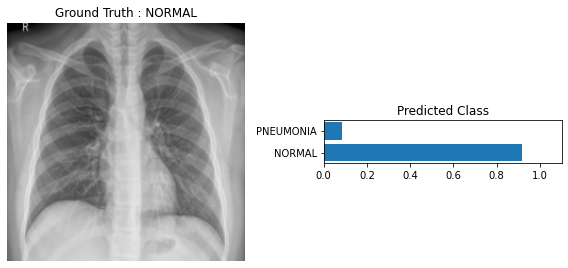

In [ ]:
import torch.nn.functional as F

image,label = testset[15]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

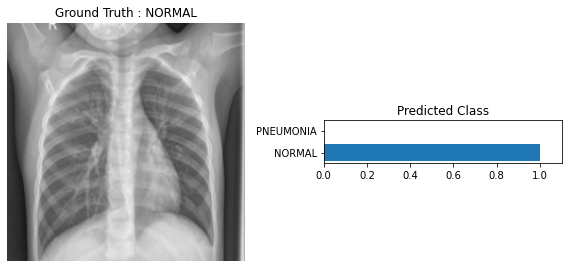

In [ ]:
import torch.nn.functional as F

image,label = testset[5]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

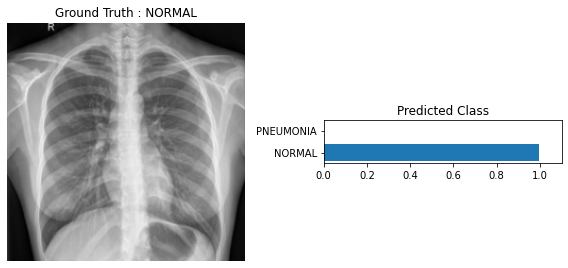

In [ ]:
import torch.nn.functional as F

image,label = testset[10]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

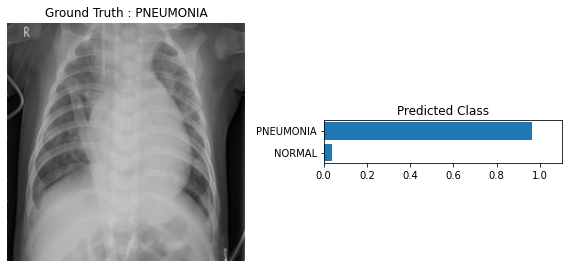

In [ ]:
import torch.nn.functional as F

image,label = testset[324]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

In [ ]:
while True:pass

KeyboardInterrupt: ignored